## Examining the Impact of Subgrid Parameters on C-M Relationship

This notebook examines the effect of the Mass Loading Fraction in the subrid model on the concentration-mass relationship. Your halo properties file should be drawn from the 64 SCIDAC runs. It also demonstrates the importance of using "select" calls for performance. Because the OpenCosmo toolkit handles most of the data management, almost all the code in the notebook is just for plotting.

You might be thinking "wouldn't it be great if the toolkit could do this for me?" We agree. Plotting routines are on the list of important features. If you have a particular plot you'd like included, consider [submitting a feature request](https://github.com/ArgonneCPAC/OpenCosmo/issues/new?template=feature_request.md)

In [97]:
import opencosmo as oc

import matplotlib.pyplot as plt
from matplotlib import cm, colors
from scipy.stats import binned_statistic
import numpy as np
from time import time

ds = oc.open("filtered_haloproperties.hdf5")
print(ds)
# It should be a SimulationCollection with 64 sub-collections OR datasets

SimulationCollection(64 collections, 0 datasets)


### Plotting Without Select

This next cell plots the C-M relationship in terms of the selected parameter. Depending on how you queried the data, your individual items might be opencosmo Datasets, or opencosmo StructureCollections. The try-except block in the center ensures the plot suceeds either way.

Completed plotting the series in 0.729 seconds


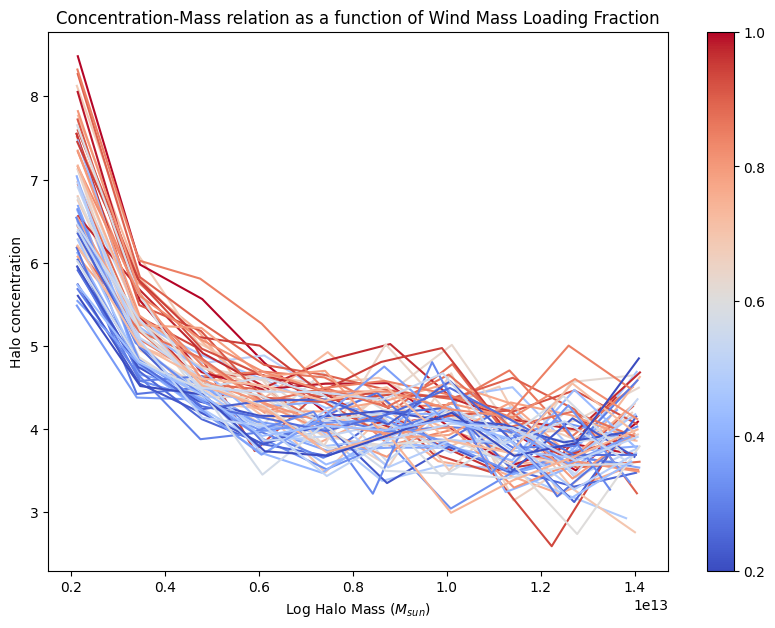

In [102]:
start = time()

plt.figure(figsize=(10,7))
series = {}
for sim in ds.values():
    wind_mass_loading = sim.simulation.subgrid_parameters.wind_egy_w
    try:
        halo_properties = sim.properties.data
    except AttributeError:
        halo_properties = sim.data
    (means,bin_edges,_) = binned_statistic(halo_properties['sod_halo_mass'], halo_properties['sod_halo_cdelta'])
    bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
    series[wind_mass_loading] = (bin_centers, means)
    
min_ = min(series.keys())
max_ = max(series.keys())
d = max_ - min_

# Compute the histogram and plot in seperate steps, so that we can get an accurate colorbar
for wind_mass_loading, (bin_centers, means) in series.items():
    c = (wind_mass_loading - min_) / d
    plt.plot(bin_centers, means, c = cm.coolwarm(c))
end = time()

print(f"Completed plotting the series in {round(end-start,3)} seconds")
plt.title("Concentration-Mass relation as a function of Wind Mass Loading Fraction")
plt.xlabel("Log Halo Mass ($M_{sun}$)")
plt.ylabel("Halo concentration")

# Create a colorbar
norm = colors.Normalize(vmin=min_, vmax=max_) 
sm = plt.cm.ScalarMappable(cmap=cm.coolwarm, norm=norm) 
sm.set_array([]) 
plt.colorbar(sm, ticks=np.linspace(min_, max_, 5), ax=plt.gca()) 


### Plotting With Select

Opencosmo reads data lazily, meaning it remains on disk until it is actually needed. The dataset itself includes many columns that are unnecessary for the plot we are trying to produce. By selecting those columns ahead of time, we can speed up the plotting process by about a factor of 10. Although this doesn't really matter for a single plot in a Jupyter notebook, for complex and long-running anlyses this is a huge difference.

Completed plotting the series in 0.066 seconds


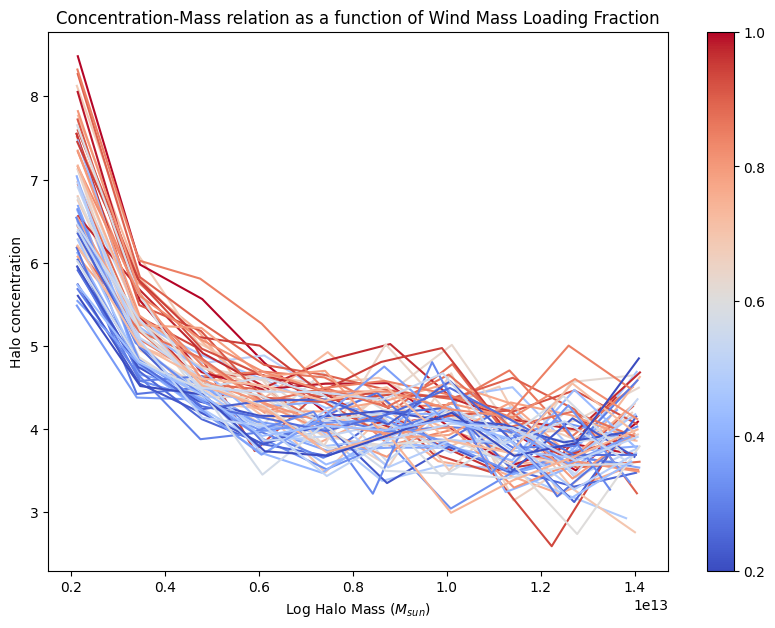

In [103]:
start = time()

plt.figure(figsize=(10,7))
series = {}
for sim in ds.values():
    wind_mass_loading = sim.simulation.subgrid_parameters.wind_egy_w
    sim_ = sim.select(["sod_halo_mass", "sod_halo_cdelta"])
    # select is the same whether you have a Dataset or StructureCollection
    
    try:
        halo_properties = sim_.properties.data
    except AttributeError:
        halo_properties = sim_.data
        
    (means,bin_edges,_) = binned_statistic(halo_properties['sod_halo_mass'], halo_properties['sod_halo_cdelta'])
    bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
    series[wind_mass_loading] = (bin_centers, means)
    
min_ = min(series.keys())
max_ = max(series.keys())
d = max_ - min_

for wind_mass_loading, (bin_centers, means) in series.items():
    c = (wind_mass_loading - min_) / d
    plt.plot(bin_centers, means, c = cm.coolwarm(c))
end = time()
print(f"Completed plotting the series in {round(end-start,3)} seconds")
plt.title("Concentration-Mass relation as a function of Wind Mass Loading Fraction")
plt.xlabel("Log Halo Mass ($M_{sun}$)")
plt.ylabel("Halo concentration")

norm = colors.Normalize(vmin=min_, vmax=max_) 
  
# creating ScalarMappable 
sm = plt.cm.ScalarMappable(cmap=cm.coolwarm, norm=norm) 
sm.set_array([]) 
  
plt.colorbar(sm, ticks=np.linspace(min_, max_, 5), ax=plt.gca()) 

### Possible Next Steps

- What about other subgrid parameters?
- What about the relationship between halo mass and galaxy stellar mass?

In [ ]:
What about the 